## 5.3.5 Binomial distribution and Krawtchouk-chaos

$$ f(k; p, N) = \binom{N}{k} p^k (1-p)^{N-k}$$

When $p=0.5, N=5$, then $k\sim B(5, 0.5)$; when $p=0.2, N=5$, then $k\sim B(5, 0.2)$; 


$$ \zeta \sim B(5, 0.5) \text{ or } B(5, 0.2)$$

Krawtchouk Polynomial (Different from polynomials in Wiki)

$$
\begin{align*}
K_0(x; p, N) &= 1\\
K_1(x; p, N) &= 1-\frac{x}{Np}\\
K_2(x; p, N) &= 1-\frac{2x}{Np}+\frac{x^2-x}{p^2(N^2-N)}\\
K_3(x; p, N) &= 1-\frac{3x}{Np}+\frac{3(x^2-x)}{p^2(N^2-N)}+\frac{(-1)(-x^3+3x^2-2x)}{p^3(-N^3+3N^2-2N)}\\
K_4(x; p, N) &= 1-\frac{4x}{Np}+\frac{6(x^2-x)}{p^2(N^2-N)}+\frac{-4(-x^3+3x^2-2x)}{p^3(-N^3+3N^2-2N)}+\frac{x^4-6x^3+11x^2-6x}{p^4(N^4-6N^3+11N^2-6N)}\\
\cdots
\end{align*}
$$

$$ K_n(x; p, N) =\ _2F_1(-n,-x;-N;\frac{1}{p})$$

[Binom in Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)

In [11]:
-0.768-1.44-3.2-6

-11.408000000000001

In [7]:
import numpy as np
from scipy.stats import binom
from math import factorial
from matplotlib import pyplot as plt
from scipy.integrate import odeint

%matplotlib notebook

In [2]:
def Krawt(params):
    '''
    The first 4 (degree from 0 to 4) Krawtchouk polynomial
    Follow definition on P641
    '''
    n = params[0]  #degree
    p = params[1]  #parameter value
    N = params[2]  #parameter value
    if n==0:
        return lambda u: 1
    elif n==1:
        return lambda u: 1-u/(N*p)
    elif n==2:
        return lambda u: 1-2*u/(N*p)+(u**2-u)/(p**2*(N**2-N))
    elif n==3:
        return lambda u: 1-3*u/(N*p)+3*(u**2-u)/(p**2*(N**2-N))+(-1)*(-u**3+3*u**2-2*u)/(p**3*(-N**3+3*N**2-2*N))
    else: #this actually means n=4
        return lambda u: 1-4*u/(N*p)+6*(u**2-u)/(p**2*(N**2-N))+(-4)*(-u**3+3*u**2-2*u)/(p**3*(-N**3+3*N**2-2*N))+(u**4-6*u**3+11*u**2-6*u)/(p**4*(N**4-6*N**3+11*N**2-6*N))

def factorial_rev(params):
    '''
    define Pochhammer symbol (a)_n
    '''
    a=params[0]
    n=params[1]
    y=1
    if n == 0:
        return 1
    else:
        for i in range(n):
            y*=a+i
        return y
    
############# Charlier Chaos ###############
def inner2_kr(params):
    '''
    n is the degree of Krawtchouk polynomial
    p is the parameter of binomial
    N is the parameter of binomial
    '''
    n = params[0]
    p = params[1]
    N = params[2]
    return (-1)**n*factorial(n)*((1-p)/p)**n/factorial_rev((-1*N,n))


def product3_kr(i,j,l,params):
    #compute \Phi_i*\Phi_j*\Phi_l
    p = params[0]
    N = params[1]
    return lambda x: Krawt((i,p,N))(x)*Krawt((j,p,N))(x)*Krawt((l,p,N))(x)

def inner3_kr(i,j,l,params):
    #compute <\Phi_i\Phi_j\Phi_l>
    inner = 0 
    p = params[0]
    N = params[1]
    for k in range(N+1):
        inner += factorial(N)*(p**k)*((1-p)**(N-k))*product3_kr(i,j,l,params)(k)/(factorial(k)*factorial(N-k))
    
    return inner

In [12]:
def ode_system_kr(y, t, P, params):   
    #P indicates the highest degree
    p = params[0]
    N = params[1]
    
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_kr(i,j,l,params)*ki_kr[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_kr((l,p,N))
    return dydt

In [13]:
P = 4
params = [0.5, 5]

ki_kr = [2.5,-2.5]+[0]*(P-1)
sol_kr = odeint(ode_system_kr, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, params)) 

In [5]:
def y_determ_kr(x):
    return np.e**(-2.5*x)

<font color = red> 
-  **There is no $y_4$ plot in the paper.**
-  **The following plot is different from the paper.**
-  **First plot different, but I got the second error plot correct. Interesting!**

In [ ]:
plt.figure(1)
plt.ylim([-0.2,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,sol_kr[:,i],label=i)

plt.plot(x, y_determ_kr(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

<IPython.core.display.Javascript object>


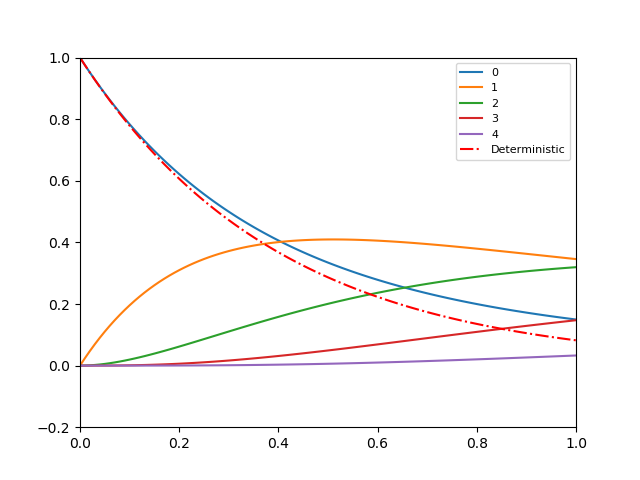

In [8]:
plt.figure(1)
plt.ylim([-0.2,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,sol_kr[:,i],label=i)

plt.plot(x, y_determ_kr(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

### Error plot
$$
\bar{y}_{exact}(t) = \hat{y_0} (1-p+pe^{-t})^N \ \ \ \ \ \ \ \ \bar{y}(t) = y_0
$$
So 
$$
\epsilon_{mean}(t) = \left| \frac{\bar{y}(t) - \bar{y}_{exact}(t)}{\bar{y}_{exact}(t)}\right|
$$

$$
\sigma_{exact}(t) = \hat{y_0}^2(1-p+pe^{-2t})^N -\hat{y_0}^2(1-p+pe^{-t})^{2N}  \ \ \ \ \ \ \ \ \sigma(t) = a_1y_1^2 +a_2y_2^2+a_3y_3^2+a_4y_4^2
$$
The coefficients $(a_1, a_2, a_3, a_4)$ in $\sigma(t)$ can be obtained by code below.

So
$$
\epsilon_{variance}(t) = \left| \frac{\sigma(t) - \sigma_{exact}(t)}{\sigma_{exact}(t)} \right|= \ldots
$$

<font color = red>This is $p=0.5, N=5$
$\downarrow$

In [9]:
allcoeff_535_1 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_535_1[0,:]=2.5*np.ones(4)
allcoeff_535_1[1,:]=-2.5*np.ones(4)
y_535_1 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

params = [0.5, 5]
for i in range(4):
    P=i+1
    ki_kr = allcoeff_535_1[:,i]
    y_mid=odeint(ode_system_kr, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, params))[1,:]
    y_535_1[:,i] = y_mid.tolist()+[0]*(4-P)

In [33]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(binom.expect(Krawt((i,0.5,5)), args=(5, 0.5), loc=0, lb=None, ub=None, conditional=False))

1.0
-2.7755575615628914e-17
-8.326672684688674e-17
2.7755575615628914e-17
-6.938893903907228e-17
-6.938893903907228e-17
-6.938893903907228e-17
-6.938893903907228e-17
-6.938893903907228e-17


In [34]:
def g(params):
    n = params
    return lambda u: (Krawt((n,0.5,5))(u))**2

for i in range(1,5):
    #to compute $\sigma^2(t)$
    print(binom.expect(g(i), args=(5, 0.5), loc=0, lb=None, ub=None, conditional=False))

0.19999999999999996
0.09999999999999998
0.09999999999999999
0.20000000000000007


In [35]:
p = 0.5
N = 5

mean_535_1 = y_535_1[0,:]
mean_exact_535_1 = (1-p+p*np.e**(-1))**N
error_mean_535_1=np.abs((mean_535_1 - mean_exact_535_1)/mean_exact_535_1)


sigma2_535_1=np.zeros(4)
for i in range(4):
    sigma2_535_1[i]=0.2*y_535_1[1,i]**2+0.1*y_535_1[2,i]**2+0.1*y_535_1[3,i]**2+0.2*y_535_1[4,i]**2
    
sigma2_exact_535_1 = (1-p+p*np.e**(-2))**N - (1-p+p*np.e**(-1))**(2*N)
error_var_535_1=np.abs((sigma2_535_1-sigma2_exact_535_1)/sigma2_exact_535_1)


<font color = red>This is $p=0.2, N=5$
$\downarrow$

In [36]:
allcoeff_535_2 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_535_2[0,:]=np.ones(4)
allcoeff_535_2[1,:]=-1*np.ones(4)
y_535_2 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

params = [0.2, 5]

for i in range(4):
    P=i+1
    ki_kr = allcoeff_535_2[:,i]
    y_mid=odeint(ode_system_kr, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, params))[1,:]
    y_535_2[:,i] = y_mid.tolist()+[0]*(4-P)

In [39]:
y_535_2

array([[0.49751271, 0.50834881, 0.50874182, 0.50874851],
       [0.31479488, 0.36538522, 0.3680706 , 0.36813058],
       [0.        , 0.0981402 , 0.1063029 , 0.10654951],
       [0.        , 0.        , 0.01478985, 0.0154121 ],
       [0.        , 0.        , 0.        , 0.00109727]])

In [37]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(binom.expect(Krawt((i,0.2,5)), args=(5, 0.2), loc=0, lb=None, ub=None, conditional=False))

0.9999999999999997
-1.1145598333150986e-16
-8.239936510889834e-17
-3.5041414214731503e-16
-7.494005416219807e-16
-7.494005416219807e-16
-7.494005416219807e-16
-7.494005416219807e-16
-7.494005416219807e-16


In [14]:
def gdd(params):
    n = params
    return lambda u:u**n

for i in range(1,9):
    #to compute $\sigma^2(t)$
    print(binom.expect(gdd(i), args=(5, 0.2), loc=0, lb=None, ub=None, conditional=False))

1.0
1.7999999999999998
3.8800000000000003
9.672
26.958400000000008
82.05600000000003
268.4560000000001
933.1920000000003


In [21]:
11.408*0.192*2

4.380672

In [38]:
def g(params):
    n = params
    return lambda u: (Krawt((n,0.2,5))(u))**2

for i in range(1,5):
    #to compute $\sigma^2(t)$
    print(binom.expect(g(i), args=(5, 0.2), loc=0, lb=None, ub=None, conditional=False))

0.7999999999999999
1.5999999999999994
6.399999999999998
51.199999999999996


In [51]:
def g(u):
    return np.e**(-2*u)

print(binom.expect(g, args=(5, 0.2), loc=0, lb=None, ub=None, conditional=False))

def f(u):
    return np.e**(-u)

print(binom.expect(g, args=(5, 0.2), loc=0, lb=None, ub=None, conditional=False))



0.38699344845837064


In [41]:
p = 0.2
N = 5

mean_535_2 = y_535_2[0,:]
mean_exact_535_2 = (1-p+p*np.e**(-1))**N
error_mean_535_2=np.abs((mean_535_2 - mean_exact_535_2)/mean_exact_535_2)


sigma2_535_2=np.zeros(4)
for i in range(4):
    sigma2_535_2[i]=0.8*y_535_2[1,i]**2+1.6*y_535_2[2,i]**2+6.4*y_535_2[3,i]**2+51.2*y_535_2[4,i]**2
    
sigma2_exact_535_2 = (1-p+p*np.e**(-2))**N - (1-p+p*np.e**(-1))**(2*N)
error_var_535_2=np.abs((sigma2_535_2-sigma2_exact_535_2)/sigma2_exact_535_2)



<IPython.core.display.Javascript object>


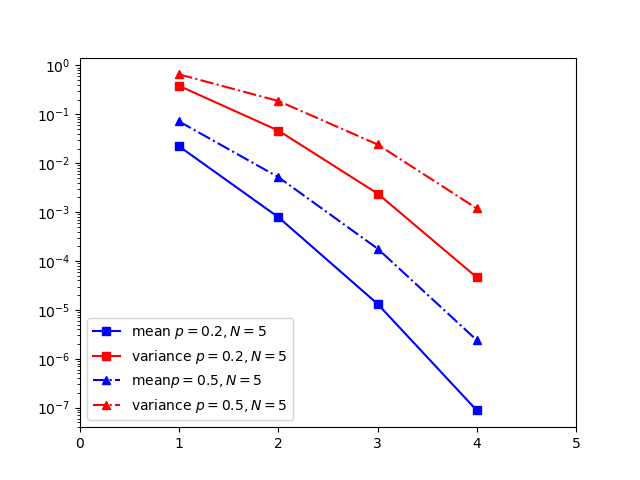

In [42]:
plt.figure(2)
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_535_2,'-bs',label='mean $p=0.2, N=5$')
plt.semilogy([1,2,3,4],error_var_535_2,'-rs',label='variance $p=0.2, N=5$')     
plt.semilogy([1,2,3,4],error_mean_535_1,'-.b^',label='mean$ p=0.5, N=5$')
plt.semilogy([1,2,3,4],error_var_535_1,'-.r^',label='variance $p=0.5, N=5$')     
plt.legend()